In [1]:
!git clone https://github.com/nateraw/huggingface-vit-finetune.git
!pip install adversarial-robustness-toolbox
# !pip install timm
%cd huggingface-vit-finetune/
!pip install -r requirements.txt
!pip install git+https://github.com/huggingface/transformers.git@master --upgrade

Cloning into 'huggingface-vit-finetune'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 10), reused 19 (delta 6), pack-reused 0
Unpacking objects: 100% (24/24), done.
     |████████████████████████████████| 972kB 8.4MB/s 
     |████████████████████████████████| 21.6MB 1.9MB/s 
     |████████████████████████████████| 3.4MB 36.6MB/s 
     |████████████████████████████████| 235kB 36.4MB/s 
     |████████████████████████████████| 747kB 34.2MB/s 
     |████████████████████████████████| 25.3MB 1.9MB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
/content/huggingface-vit-finetune
     |████████████████████████████████| 849kB 9.2MB/s 
     |████████████████████████████████| 276kB 18.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import art
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier

from transformers import ViTFeatureExtractor, ViTForImageClassification
import requests

# import timm
# from timm.data import resolve_data_config
# from timm.data.transforms_factory import create_transform

In [3]:
result_dict = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
transform = transforms.Compose(
    [
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64, shuffle=True, num_workers=2)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=False, num_workers=2)
cifar_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10', return_dict=False)
model.to(device)
# model = nn.Sequential(
#     nn.Upsample(scale_factor=7, mode='bilinear'),
#     model
# )

class Transformer(nn.Module):
  def __init__(self, model):
    super(Transformer, self).__init__()
    self.model = model
  def forward(self, x):
    return self.model(x)[0]

ViT_model = Transformer(model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViT_model.parameters(), lr=0.01)
transformer_classifier = PyTorchClassifier(
    model=ViT_model.cpu(),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

In [6]:
CNN_Model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
CNN_Model = CNN_Model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
cnn_classifier = PyTorchClassifier(
    model=CNN_Model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg16_bn-6ee7ea24.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg16_bn-6ee7ea24.pt


In [13]:
eps = 8/255
attack_PGD_10_CNN = ProjectedGradientDescentPyTorch(
        estimator=cnn_classifier,
        norm=2,
        eps=eps,
        targeted=False,
        eps_step=2/255,
        max_iter=10
)



# Saliency Map 

Predicted class:  cat


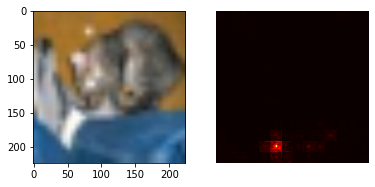

/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Attacked Predicted class:  airplane


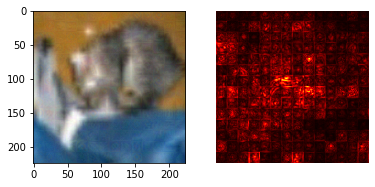

Predicted class:  dog


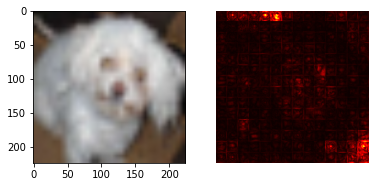

PGD10 Attacked Predicted class:  cat


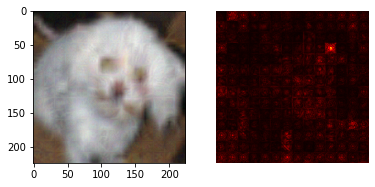

Predicted class:  automobile


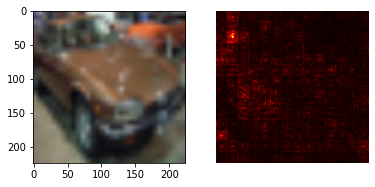

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Attacked Predicted class:  truck


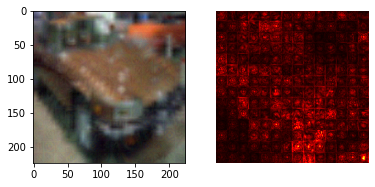

Predicted class:  dog


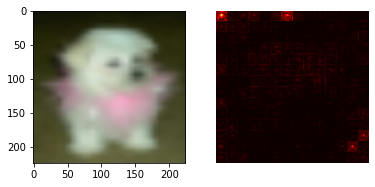

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Attacked Predicted class:  cat


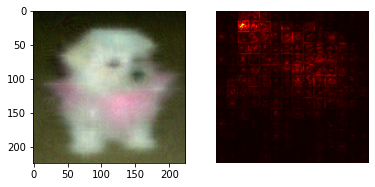

Predicted class:  airplane


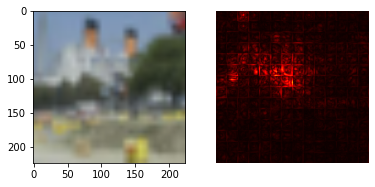

PGD10 Attacked Predicted class:  truck


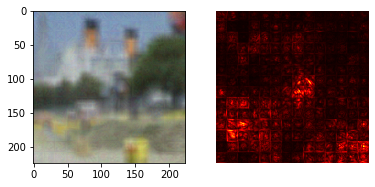

Predicted class:  horse


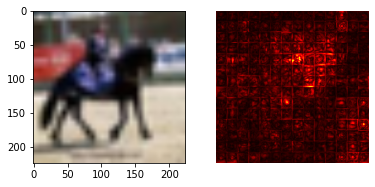

PGD10 Attacked Predicted class:  airplane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


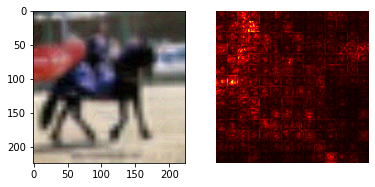

Predicted class:  ship


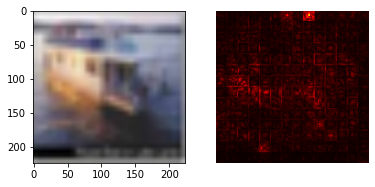

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Attacked Predicted class:  truck


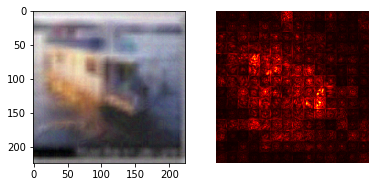

Predicted class:  bird


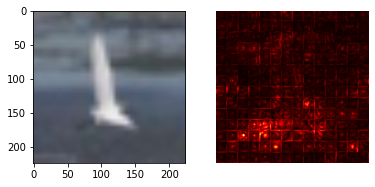

PGD10 Attacked Predicted class:  ship


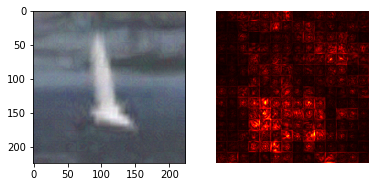

Predicted class:  truck


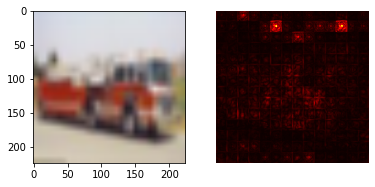

PGD10 Attacked Predicted class:  airplane


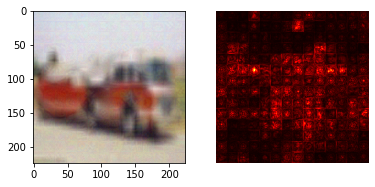

Predicted class:  ship


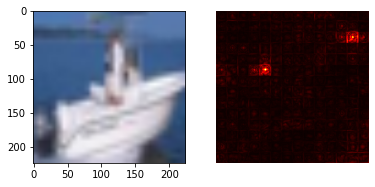

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Attacked Predicted class:  bird


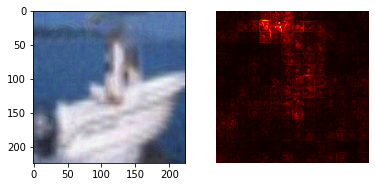

In [22]:
attack_PGD_10_ViT = ProjectedGradientDescentPyTorch(
        estimator=transformer_classifier,
        norm="inf",
        eps=8/255,
        targeted=False,
        eps_step=2/255,
        max_iter=10
)

cifar_single_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False, num_workers=2)

# cifar-10 DATASET consists of 60000 images
correct = 0
total = 0
ViT_model.to(device)
for i, (inputs, labels) in enumerate(cifar_single_testloader):
  if i % 1000 == 0:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs.requires_grad_()
    outputs = ViT_model(inputs)
    out_max_index = outputs.argmax()
    print("Predicted class: ", cifar_classes[out_max_index])
    # print(out_max_index, outputs[0].size())
    out_max = outputs[0][out_max_index]
    # print(out_max)
    out_max.backward()
    saliency, _ = torch.max(inputs.grad.data.abs(),dim=1)
    # code to plot the saliency map as a heatmap
    saliency = saliency.cpu()
    img_cpu = inputs.cpu()
    orig_img = np.swapaxes(img_cpu[0].T, 0, 1)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(orig_img.detach().numpy(), cmap='viridis')
    axes[1].imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()

    inputs = inputs.cpu()
    x_test_adv = attack_PGD_10_ViT.generate(x=inputs.detach(),batch_size = 64)
    x_test_adv = torch.tensor(x_test_adv).to(device)
    x_test_adv.requires_grad_()
    outputs = ViT_model(x_test_adv)
    out_max_index = outputs.argmax()
    print("PGD10 Attacked Predicted class: ", cifar_classes[out_max_index])
    # print(out_max_index, outputs[0].size())
    out_max = outputs[0][out_max_index]
    # print(out_max)
    out_max.backward()
    saliency, _ = torch.max(x_test_adv.grad.data.abs(),dim=1)
    # code to plot the saliency map as a heatmap
    saliency = saliency.cpu()
    img_cpu = x_test_adv.cpu()
    orig_img = np.swapaxes(img_cpu[0].T, 0, 1)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(orig_img.detach().numpy(), cmap='viridis')
    axes[1].imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()    
    


Predicted class:  cat


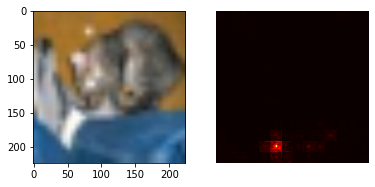

/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD20L2 Atk Predicted class:  cat


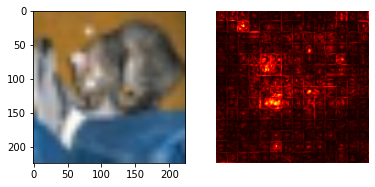

Predicted class:  dog


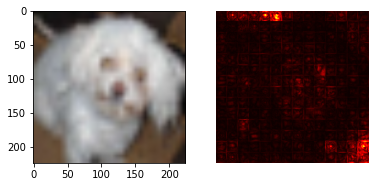

PGD20L2 Atk Predicted class:  dog


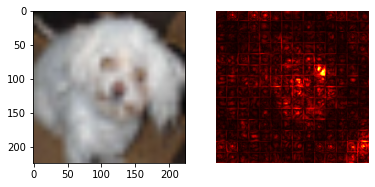

Predicted class:  automobile


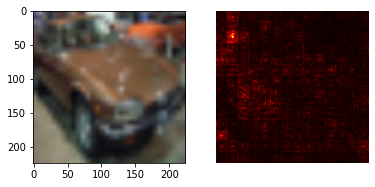

PGD20L2 Atk Predicted class:  automobile


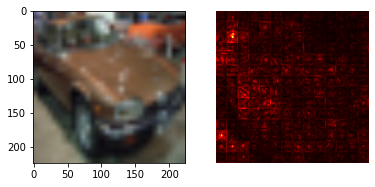

Predicted class:  dog


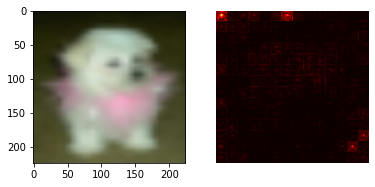

PGD20L2 Atk Predicted class:  dog


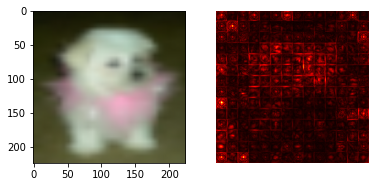

Predicted class:  airplane


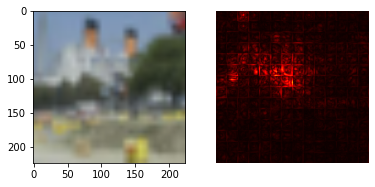

PGD20L2 Atk Predicted class:  airplane


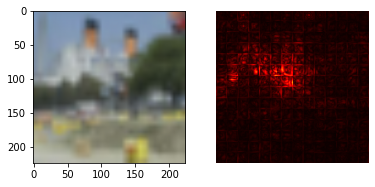

Predicted class:  horse


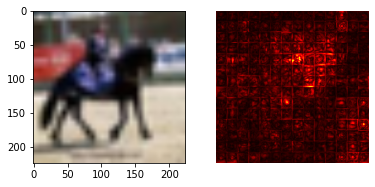

PGD20L2 Atk Predicted class:  horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


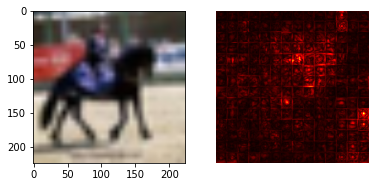

Predicted class:  ship


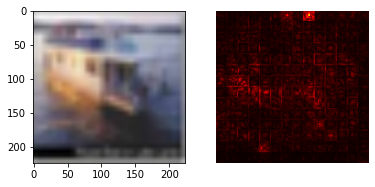

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD20L2 Atk Predicted class:  ship


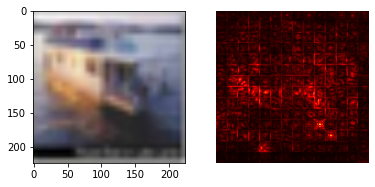

Predicted class:  bird


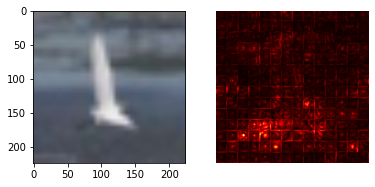

PGD20L2 Atk Predicted class:  bird


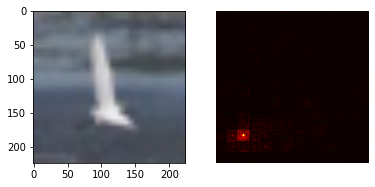

Predicted class:  truck


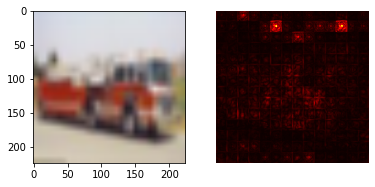

PGD20L2 Atk Predicted class:  truck


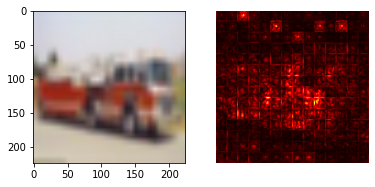

Predicted class:  ship


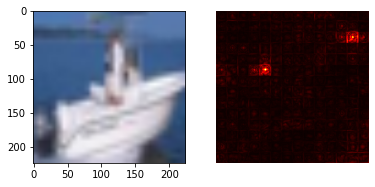

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD20L2 Atk Predicted class:  ship


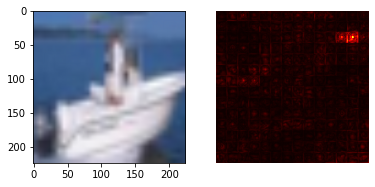

In [24]:
attack_PGD_20_L2_ViT = ProjectedGradientDescentPyTorch(
        estimator=transformer_classifier,
        norm=2,
        eps=8/255,
        targeted=False,
        eps_step=2/255,
        max_iter=20
)

cifar_single_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False, num_workers=2)

# cifar-10 DATASET consists of 60000 images
correct = 0
total = 0
ViT_model.to(device)
for i, (inputs, labels) in enumerate(cifar_single_testloader):
  if i % 1000 == 0:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs.requires_grad_()
    outputs = ViT_model(inputs)
    out_max_index = outputs.argmax()
    print("Predicted class: ", cifar_classes[out_max_index])
    # print(out_max_index, outputs[0].size())
    out_max = outputs[0][out_max_index]
    # print(out_max)
    out_max.backward()
    saliency, _ = torch.max(inputs.grad.data.abs(),dim=1)
    # code to plot the saliency map as a heatmap
    saliency = saliency.cpu()
    img_cpu = inputs.cpu()
    orig_img = np.swapaxes(img_cpu[0].T, 0, 1)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(orig_img.detach().numpy(), cmap='viridis')
    axes[1].imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()

    inputs = inputs.cpu()
    x_test_adv = attack_PGD_20_L2_ViT.generate(x=inputs.detach(),batch_size = 64)
    x_test_adv = torch.tensor(x_test_adv).to(device)
    x_test_adv.requires_grad_()
    outputs = ViT_model(x_test_adv)
    out_max_index = outputs.argmax()
    print("PGD20L2 Atk Predicted class: ", cifar_classes[out_max_index])
    # print(out_max_index, outputs[0].size())
    out_max = outputs[0][out_max_index]
    # print(out_max)
    out_max.backward()
    saliency, _ = torch.max(x_test_adv.grad.data.abs(),dim=1)
    # code to plot the saliency map as a heatmap
    saliency = saliency.cpu()
    img_cpu = x_test_adv.cpu()
    orig_img = np.swapaxes(img_cpu[0].T, 0, 1)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(orig_img.detach().numpy(), cmap='viridis')
    axes[1].imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()    
    


In [25]:
attack_PGD_20_L2_ViT = ProjectedGradientDescentPyTorch(
        estimator=transformer_classifier,
        norm=2,
        eps=8/255,
        targeted=False,
        eps_step=2/255,
        max_iter=20
)

correct = 0
total = 0
for i, (inputs, labels) in enumerate(cifar_testloader):
  inputs, labels = inputs.cpu(), labels.numpy()
  x_test_adv = attack_PGD_20_L2_ViT.generate(x=inputs,batch_size = 64)
  outputs = transformer_classifier.predict(x_test_adv)
  predicted = np.argmax(outputs, 1)
  total += labels.size
  correct += (predicted == labels).sum().item()
  if(i % 10 == 0):
    print('Accuracy on %d pgd20L2 cifar-10 test images: %f %%' % (total, 100 * correct / total))


print('Accuracy of the network on %d pgd20L2 cifar-10 test images: %f %%' % (
    total,
    100 * correct / total))
result_dict["Transformer_PGD20L2_on_ViT"] = 100 * correct / total

/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


Accuracy on 64 pgd20L2 cifar-10 test images: 95.312500 %


Accuracy on 704 pgd20L2 cifar-10 test images: 98.863636 %


Accuracy on 1344 pgd20L2 cifar-10 test images: 98.809524 %


Accuracy on 1984 pgd20L2 cifar-10 test images: 98.689516 %


Accuracy on 2624 pgd20L2 cifar-10 test images: 98.628049 %


Accuracy on 3264 pgd20L2 cifar-10 test images: 98.713235 %


Accuracy on 3904 pgd20L2 cifar-10 test images: 98.744877 %


Accuracy on 4544 pgd20L2 cifar-10 test images: 98.745599 %


Accuracy on 5184 pgd20L2 cifar-10 test images: 98.649691 %


Accuracy on 5824 pgd20L2 cifar-10 test images: 98.626374 %


Accuracy on 6464 pgd20L2 cifar-10 test images: 98.607673 %


Accuracy on 7104 pgd20L2 cifar-10 test images: 98.578266 %


Accuracy on 7744 pgd20L2 cifar-10 test images: 98.514979 %


Accuracy on 8384 pgd20L2 cifar-10 test images: 98.473282 %


Accuracy on 9024 pgd20L2 cifar-10 test images: 98.459663 %


Accuracy on 9664 pgd20L2 cifar-10 test images: 98.468543 %


Accuracy of the network on 10000 pgd20L2 cifar-10 test images: 98.450000 %


In [28]:
transform32 = transforms.Compose(
    [
      # transforms.Resize((224, 224)),
      transforms.ToTensor(),
      # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
cifar_testset32 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform32)
cifar_testloader32 = torch.utils.data.DataLoader(cifar_testset32, batch_size=64, shuffle=False, num_workers=2)

attack_PGD_20_L2_CNN = ProjectedGradientDescentPyTorch(
        estimator=cnn_classifier,
        norm=2,
        eps=eps,
        targeted=False,
        eps_step=2/255,
        max_iter=20
)

correct = 0
total = 0
for i, (inputs, labels) in enumerate(cifar_testloader32):
  inputs, labels = inputs.cpu(), labels.numpy()
  x_test_adv = attack_PGD_20_L2_CNN.generate(x=inputs,batch_size = 64)
  outputs = cnn_classifier.predict(x_test_adv)
  predicted = np.argmax(outputs, 1)
  total += labels.size
  correct += (predicted == labels).sum().item()
  if(i % 10 == 0):
    print('Accuracy on %d cifar-10 test images: %f %%' % (total, 100 * correct / total))


print('Accuracy of CNN on %d pgd20L2 cifar-10 test images: %f %%' % (
    total,
    100 * correct / total))
result_dict["CNN_PGD_20L2_on_ViT"] = 100 * correct / total

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


Accuracy on 64 cifar-10 test images: 26.562500 %


Accuracy on 704 cifar-10 test images: 30.823864 %


Accuracy on 1344 cifar-10 test images: 32.068452 %


Accuracy on 1984 cifar-10 test images: 32.258065 %


Accuracy on 2624 cifar-10 test images: 32.583841 %


Accuracy on 3264 cifar-10 test images: 32.598039 %


Accuracy on 3904 cifar-10 test images: 32.684426 %


Accuracy on 4544 cifar-10 test images: 33.142606 %


Accuracy on 5184 cifar-10 test images: 33.043981 %


Accuracy on 5824 cifar-10 test images: 32.760989 %


Accuracy on 6464 cifar-10 test images: 33.013614 %


Accuracy on 7104 cifar-10 test images: 32.911036 %


Accuracy on 7744 cifar-10 test images: 33.006198 %


Accuracy on 8384 cifar-10 test images: 32.752863 %


Accuracy on 9024 cifar-10 test images: 32.668440 %


Accuracy on 9664 cifar-10 test images: 32.657285 %


Accuracy of CNN on 10000 pgd20L2 cifar-10 test images: 32.650000 %


In [29]:
# ViT32 robustness on L2 pgd:
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10', return_dict=False)
model.to(device)
model = nn.Sequential(
    nn.Upsample(scale_factor=7, mode='bilinear'),
    model
)

ViT_model32 = Transformer(model).to(device)
transformer_classifier32 = PyTorchClassifier(
    model=ViT_model32,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

In [39]:
attack_PGD_20_L2_ViT32 = ProjectedGradientDescentPyTorch(
        estimator=transformer_classifier32,
        norm=2,
        eps=8/255,
        targeted=False,
        eps_step=2/255,
        max_iter=20
)

correct = 0
total = 0
for i, (inputs, labels) in enumerate(cifar_testloader32):
  inputs, labels = inputs.to(device), labels.numpy()
  # print(labels.size(0))
  x_test_adv = attack_PGD_20_L2_ViT32.generate(x=inputs.cpu(),batch_size = 64)
  outputs = transformer_classifier32.predict(x_test_adv)
  predicted = np.argmax(outputs, 1)
  total += labels.size
  # print(predicted, labels, (predicted == labels))
  # print(np.sum(predicted == labels))
  correct += (predicted == labels).sum().item()
  if(i % 10 == 0):
    print('Accuracy on %d pgd20L2 cifar-10 test images: %f %%' % (total, 100 * correct / total))


print('Accuracy of ViT32 on %d pgd20L2 cifar-10 test images: %f %%' % (
    total,
    100 * correct / total))
result_dict["Transformer_PGD20L2_on_ViT32"] = 100 * correct / total

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


Accuracy on 64 pgd20L2 cifar-10 test images: 95.312500 %


Accuracy on 704 pgd20L2 cifar-10 test images: 96.590909 %


Accuracy on 1344 pgd20L2 cifar-10 test images: 97.098214 %


Accuracy on 1984 pgd20L2 cifar-10 test images: 97.127016 %


Accuracy on 2624 pgd20L2 cifar-10 test images: 96.913110 %


Accuracy on 3264 pgd20L2 cifar-10 test images: 96.936275 %


Accuracy on 3904 pgd20L2 cifar-10 test images: 96.823770 %


Accuracy on 4544 pgd20L2 cifar-10 test images: 96.808979 %


Accuracy on 5184 pgd20L2 cifar-10 test images: 96.817130 %


Accuracy on 5824 pgd20L2 cifar-10 test images: 96.926511 %


Accuracy on 6464 pgd20L2 cifar-10 test images: 96.828589 %


Accuracy on 7104 pgd20L2 cifar-10 test images: 96.832770 %


Accuracy on 7744 pgd20L2 cifar-10 test images: 96.823347 %


Accuracy on 8384 pgd20L2 cifar-10 test images: 96.755725 %


Accuracy on 9024 pgd20L2 cifar-10 test images: 96.753103 %


Accuracy on 9664 pgd20L2 cifar-10 test images: 96.709437 %


Accuracy of ViT32 on 10000 pgd20L2 cifar-10 test images: 96.690000 %


In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for i, (inputs, labels) in enumerate(cifar_testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = CNN_Model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    if(i % 10 == 0):
      print('Accuracy of the network on %d cifar-10 test images: %f %%' % (total, 100 * correct / total))


print('Accuracy of the network on %d cifar-10 test images: %f %%' % (
    total,
    100 * correct / total))
result_dict["CNN"] = 100 * correct / total

Accuracy of the network on 64 cifar-10 test images: 90.625000 %
Accuracy of the network on 704 cifar-10 test images: 94.886364 %
Accuracy of the network on 1344 cifar-10 test images: 93.898810 %
Accuracy of the network on 1984 cifar-10 test images: 93.094758 %
Accuracy of the network on 2624 cifar-10 test images: 92.492378 %
Accuracy of the network on 3264 cifar-10 test images: 92.861520 %
Accuracy of the network on 3904 cifar-10 test images: 92.622951 %
Accuracy of the network on 4544 cifar-10 test images: 92.781690 %
Accuracy of the network on 5184 cifar-10 test images: 92.689043 %
Accuracy of the network on 5824 cifar-10 test images: 92.754121 %
Accuracy of the network on 6464 cifar-10 test images: 92.821782 %
Accuracy of the network on 7104 cifar-10 test images: 92.877252 %
Accuracy of the network on 7744 cifar-10 test images: 92.884814 %
Accuracy of the network on 8384 cifar-10 test images: 92.867366 %
Accuracy of the network on 9024 cifar-10 test images: 92.752660 %
Accuracy of t

# Attack CNN model

CNN Predicted Class:  cat
Sum of saliency map:  370.5124206542969


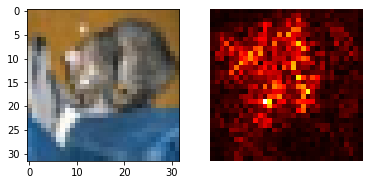

/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Atk Predicted Class:  dog
Sum of saliency map:  35.67420196533203


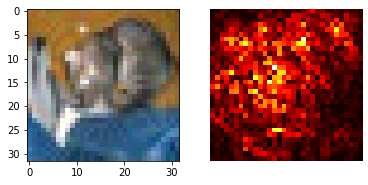

CNN Predicted Class:  dog
Sum of saliency map:  289.96392822265625


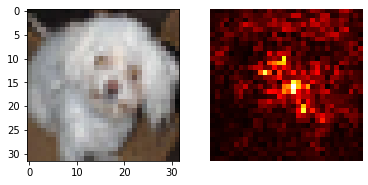

PGD10 Atk Predicted Class:  cat
Sum of saliency map:  35.08732986450195


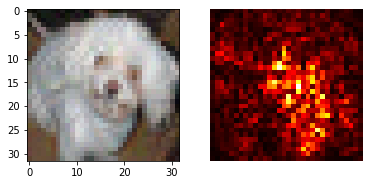

CNN Predicted Class:  frog
Sum of saliency map:  601.1990966796875


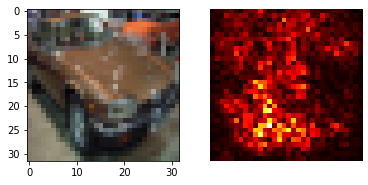

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Atk Predicted Class:  deer
Sum of saliency map:  22.903987884521484


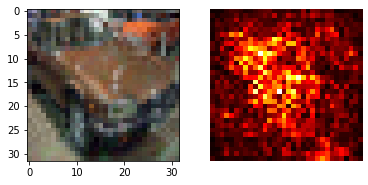

CNN Predicted Class:  dog
Sum of saliency map:  148.885498046875


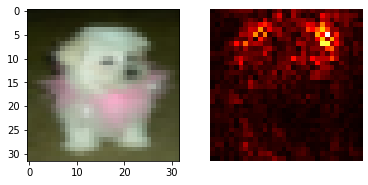

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Atk Predicted Class:  airplane
Sum of saliency map:  206.92767333984375


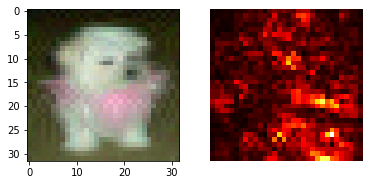

CNN Predicted Class:  dog
Sum of saliency map:  173.80520629882812


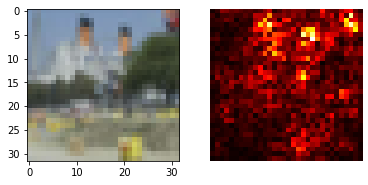

PGD10 Atk Predicted Class:  airplane
Sum of saliency map:  102.02885437011719


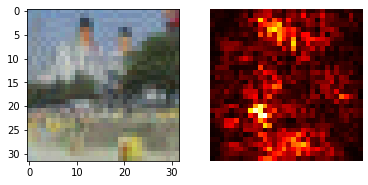

CNN Predicted Class:  horse
Sum of saliency map:  75.11260223388672


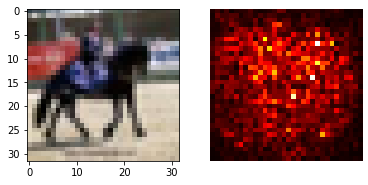

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Atk Predicted Class:  frog
Sum of saliency map:  21.188304901123047


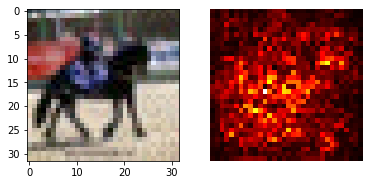

CNN Predicted Class:  deer
Sum of saliency map:  358.9658508300781


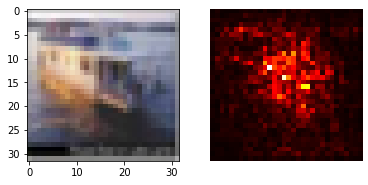

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Atk Predicted Class:  dog
Sum of saliency map:  84.96218872070312


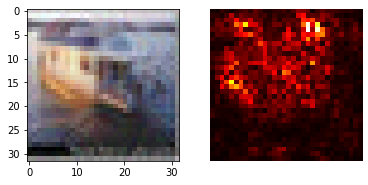

CNN Predicted Class:  airplane
Sum of saliency map:  227.4068145751953


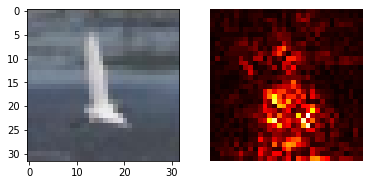

PGD10 Atk Predicted Class:  cat
Sum of saliency map:  124.08562469482422


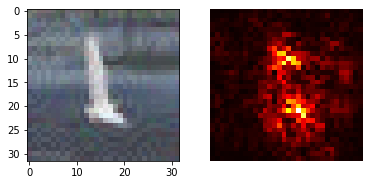

CNN Predicted Class:  deer
Sum of saliency map:  723.3021850585938


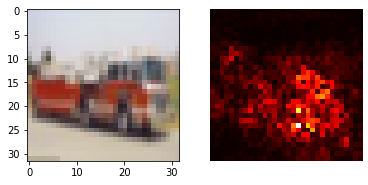

PGD10 Atk Predicted Class:  cat
Sum of saliency map:  58.57027053833008


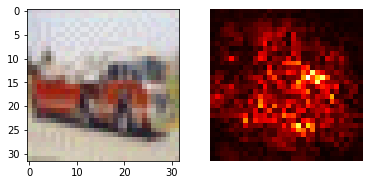

CNN Predicted Class:  ship
Sum of saliency map:  309.2879943847656


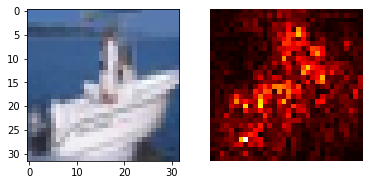

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Atk Predicted Class:  dog
Sum of saliency map:  56.90852737426758


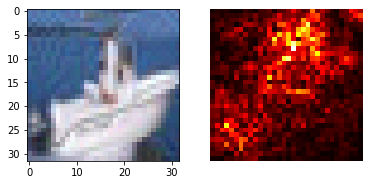

In [51]:
attack_PGD_10_CNN = ProjectedGradientDescentPyTorch(
        estimator=cnn_classifier,
        norm="inf",
        eps=8/255,
        targeted=False,
        eps_step=2/255,
        max_iter=10
)

cifar_single_testloader32 = torch.utils.data.DataLoader(cifar_testset32, batch_size=1, shuffle=False, num_workers=2)

# cifar-10 DATASET consists of 60000 images
correct = 0
total = 0
for i, (inputs, labels) in enumerate(cifar_single_testloader32):
  if i % 1000 == 0:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs.requires_grad_()
    outputs = CNN_Model(inputs)
    out_max_index = outputs.argmax()
    print("CNN Predicted Class: ", cifar_classes[out_max_index])
    # print(out_max_index, outputs[0].size())
    out_max = outputs[0][out_max_index]
    # print(out_max)
    out_max.backward()
    saliency, _ = torch.max(inputs.grad.data.abs(),dim=1)
    # code to plot the saliency map as a heatmap
    saliency = saliency.cpu()
    print("Sum of saliency map: ", saliency[0].sum().item())
    img_cpu = inputs.cpu()
    orig_img = np.swapaxes(img_cpu[0].T, 0, 1)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(orig_img.detach().numpy(), cmap='viridis')
    axes[1].imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()

    x_test_adv = attack_PGD_10_CNN.generate(x=inputs.detach().cpu(),batch_size = 64)
    x_test_adv = torch.tensor(x_test_adv).to(device)
    x_test_adv.requires_grad_()
    outputs = CNN_Model(x_test_adv)
    out_max_index = outputs.argmax()
    print("PGD10 Atk Predicted Class: ", cifar_classes[out_max_index])
    # print(out_max_index, outputs[0].size())
    out_max = outputs[0][out_max_index]
    # print(out_max)
    out_max.backward()
    saliency, _ = torch.max(x_test_adv.grad.data.abs(),dim=1)
    # code to plot the saliency map as a heatmap
    saliency = saliency.cpu()
    print("Sum of saliency map: ", saliency[0].sum().item())
    img_cpu = x_test_adv.cpu()
    orig_img = np.swapaxes(img_cpu[0].T, 0, 1)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(orig_img.detach().numpy(), cmap='viridis')
    axes[1].imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ViT32 Predicted Class:  cat
Sum of saliency map:  14.494599342346191


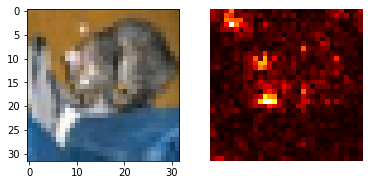

/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:694: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:695: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Attacked Predicted Class:  bird
Sum of saliency map:  232.2993621826172


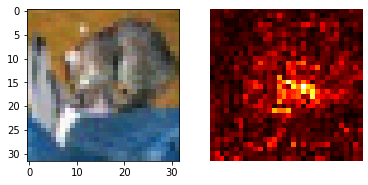

ViT32 Predicted Class:  dog
Sum of saliency map:  20.020931243896484


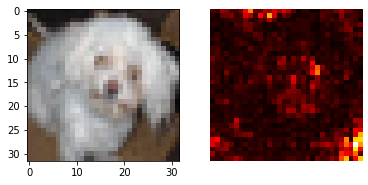

PGD10 Attacked Predicted Class:  frog
Sum of saliency map:  114.44625091552734


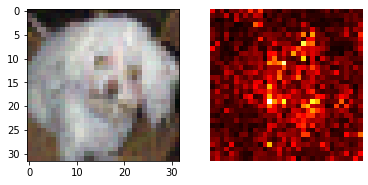

ViT32 Predicted Class:  automobile
Sum of saliency map:  10.763980865478516


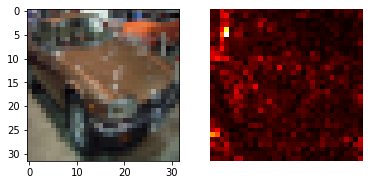

PGD10 Attacked Predicted Class:  truck
Sum of saliency map:  80.67250061035156


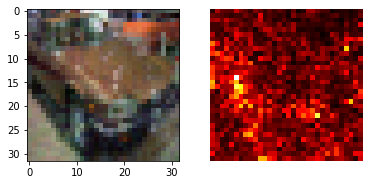

ViT32 Predicted Class:  dog
Sum of saliency map:  109.48175048828125


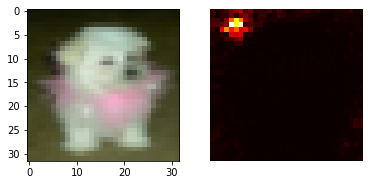

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Attacked Predicted Class:  deer
Sum of saliency map:  19.91469383239746


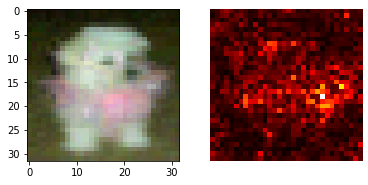

ViT32 Predicted Class:  airplane
Sum of saliency map:  1853.6484375


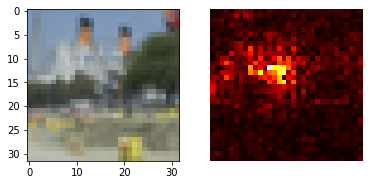

PGD10 Attacked Predicted Class:  truck
Sum of saliency map:  41.61363983154297


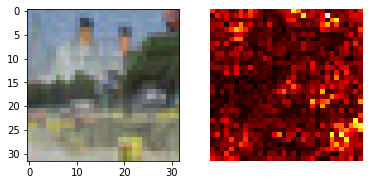

ViT32 Predicted Class:  horse
Sum of saliency map:  8.404569625854492


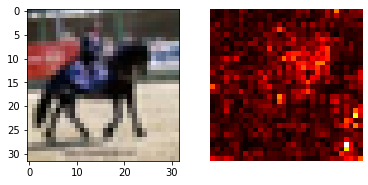

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Attacked Predicted Class:  airplane
Sum of saliency map:  203.5237274169922


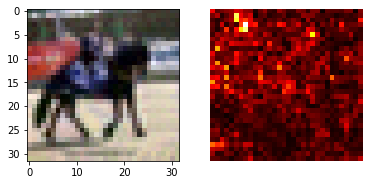

ViT32 Predicted Class:  ship
Sum of saliency map:  27.728256225585938


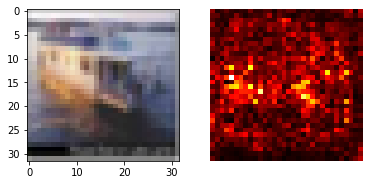

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Attacked Predicted Class:  truck
Sum of saliency map:  29.792205810546875


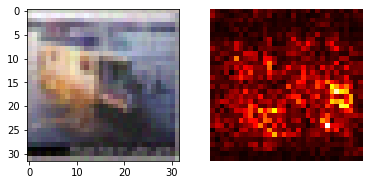

ViT32 Predicted Class:  bird
Sum of saliency map:  160.27978515625


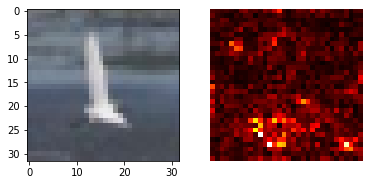

PGD10 Attacked Predicted Class:  ship
Sum of saliency map:  24.853981018066406


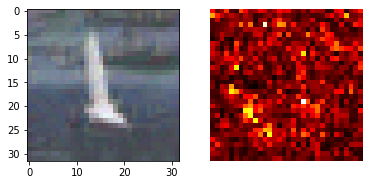

ViT32 Predicted Class:  truck
Sum of saliency map:  11.901928901672363


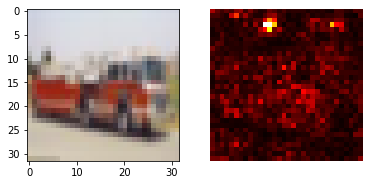

PGD10 Attacked Predicted Class:  automobile
Sum of saliency map:  24.551851272583008


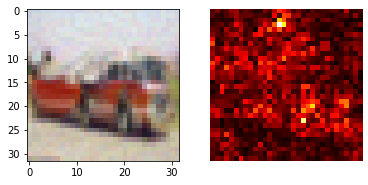

ViT32 Predicted Class:  ship
Sum of saliency map:  6.7209014892578125


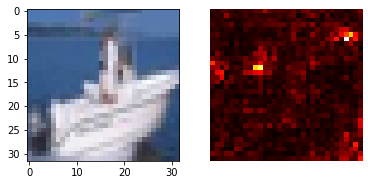

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PGD10 Attacked Predicted Class:  dog
Sum of saliency map:  52.68732833862305


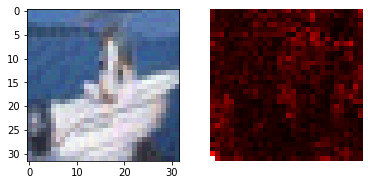

In [50]:
attack_PGD_10_ViT32 = ProjectedGradientDescentPyTorch(
        estimator=transformer_classifier32,
        norm="inf",
        eps=8/255,
        targeted=False,
        eps_step=2/255,
        max_iter=10
)

# cifar-10 DATASET consists of 60000 images
correct = 0
total = 0
ViT_model32.to(device)
for i, (inputs, labels) in enumerate(cifar_single_testloader32):
  if i % 1000 == 0:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs.requires_grad_()
    outputs = ViT_model32(inputs)
    out_max_index = outputs.argmax()
    print("ViT32 Predicted Class: ", cifar_classes[out_max_index])
    # print(out_max_index, outputs[0].size())
    out_max = outputs[0][out_max_index]
    # print(out_max)
    out_max.backward()
    saliency, _ = torch.max(inputs.grad.data.abs(),dim=1)
    # code to plot the saliency map as a heatmap
    saliency = saliency.cpu()
    print("Sum of saliency map: ", saliency[0].sum().item())
    img_cpu = inputs.cpu()
    orig_img = np.swapaxes(img_cpu[0].T, 0, 1)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(orig_img.detach().numpy(), cmap='viridis')
    axes[1].imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()

    x_test_adv = attack_PGD_10_ViT32.generate(x=inputs.detach().cpu(),batch_size = 64)
    x_test_adv = torch.tensor(x_test_adv).to(device)
    x_test_adv.requires_grad_()
    outputs = ViT_model32(x_test_adv)
    out_max_index = outputs.argmax()
    print("PGD10 Attacked Predicted Class: ", cifar_classes[out_max_index])
    # print(out_max_index, outputs[0].size())
    out_max = outputs[0][out_max_index]
    # print(out_max)
    out_max.backward()
    saliency, _ = torch.max(x_test_adv.grad.data.abs(),dim=1)
    # code to plot the saliency map as a heatmap
    saliency = saliency.cpu()
    # print(saliency[0])
    print("Sum of saliency map: ", saliency[0].sum().item())
    img_cpu = x_test_adv.cpu()
    orig_img = np.swapaxes(img_cpu[0].T, 0, 1)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(orig_img.detach().numpy(), cmap='viridis')
    axes[1].imshow(saliency[0], cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()    
    


In [ ]:
result_dict

{'CNN': 92.77,
 'CNN_PGD_10_on_ViT': 83.5,
 'CNN_PGD_1_on_ViT': 79.74,
 'CNN_PGD_20': 80.97,
 'CNN_PGD_5_on_ViT': 85.65,
 'Transformer': 98.74,
 'Transformer_PGD_10': 60.89,
 'Transformer_PGD_1_on_CNN': 56.65,
 'Transformer_PGD_5_on_CNN': 60.74}

# Results Record


